In [57]:
#pip install dataframe-image

In [79]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
#import psycopg2
#import requests
#import csv
#import os
from datetime import datetime, timedelta
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [80]:

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from keras.models import Model
#from keras.models import model_from_json

# SQL Alchemy
from sqlalchemy import create_engine
#from config import username, password

import warnings
warnings.filterwarnings('ignore')

import pickle as pkl
import yfinance as yf

plt.style.use('fivethirtyeight')

In [81]:
# def get_historical(quote):
start = "2010-01-01"
ticker = 'GOOG'
    
data = yf.download(ticker, start = start, period = "ytd")
data = data.reset_index(level=0)

df_ticker = data.drop_duplicates()
df_ticker_data = df_ticker.rename(columns={
  'Date': 'Date',  
  'Open': 'open',
  'High': 'high',
  'Low': 'low',
  'Close': 'close',
  'Adj Close': 'adjclose',
  'Volume': 'volume'
  })
#return df_ticker
df_ticker_data

[*********************100%***********************]  1 of 1 completed


,Date,open,high,low,close,adjclose,volume
0,2010-01-04,15.615220,15.678981,15.547723,15.610239,15.610239,78541293
1,2010-01-05,15.620949,15.637387,15.480475,15.541497,15.541497,120638494
2,2010-01-06,15.588072,15.588072,15.102393,15.149715,15.149715,159744526
3,2010-01-07,15.178109,15.193053,14.760922,14.797037,14.797037,257533695
4,2010-01-08,14.744733,15.024933,14.672753,14.994298,14.994298,189680313
...,...,...,...,...,...,...,...
3243,2022-11-18,99.010002,99.160004,96.739998,97.800003,97.800003,24959300
3244,2022-11-21,97.559998,98.720001,95.669998,95.830002,95.830002,18696900
3245,2022-11-22,96.160004,97.547997,94.410004,97.330002,97.330002,18868900
3246,2022-11-23,97.339996,99.069000,97.339996,98.820000,98.820000,17568900


In [84]:
def ARIMA_model(df_ticker_data):
    ## Add a dummy row at the end. This will not be used to predict. 

    df_ticker_data.loc[len(df_ticker_data)]=df_ticker_data.loc[len(df_ticker_data)-1]

    next_day = datetime.now()+timedelta(1)
    df_ticker_data.iloc[-1, df_ticker_data.columns.get_loc('Date')] = next_day
    df_ticker_data['Date'] = pd.to_datetime(df_ticker_data["Date"]).dt.date

    df_ticker_data = df_ticker_data.set_index('Date')
    df_ticker_data['avg'] = (df_ticker_data['high'] + df_ticker_data['low']) / 2
    
    train_data, test_data = df_ticker_data[0:int(len(data)*0.9)], df_ticker_data[int(len(data)*0.9):]
    
    print("----------------------------------------------------------")
    plt.figure(figsize=(16,8))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Close Prices')
    plt.plot(train_data['close'], 'green', label='Train data')
    plt.plot(test_data['close'], 'blue', label='Test data')
    plt.legend()
    print("----------------------------------------------------------")
    train_arima = train_data['avg']
    test_arima = test_data['close']
    history = [x for x in train_arima]
    y = test_arima
    # make first prediction
    predictions = list()
    #model = ARIMA(dataFrame.columnName, order=(1,0,0))
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(y[0])
    # rolling forecasts
    for i in range(1, len(y)):
        # predict
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        # invert transformed prediction
        predictions.append(yhat)
        # observation
        obs = y[i]
        history.append(obs)
    # report performance
    
    mse = mean_squared_error(y, predictions)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(y, predictions)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(y, predictions))
    print('RMSE: '+str(rmse))
    accuracy = r2_score(y, predictions)
    print('Accuracy:'+str(accuracy))
    print("----------------------------------------------------------")
    plt.figure(figsize=(16,8))
    plt.plot(train_data.index[-600:], train_data['close'].tail(600), color='green', label = 'Train Stock Price')
    plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
    plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
    title_name = ticker+ ' Stock Price Prediction'
    plt.title(title_name)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('/Users/selinasu/Desktop/testfiles/Flask-Stock-dashboard/static/image/arima_model.png')
    plt.show()

    df_pred = pd.DataFrame(test_data.index)
    df_pred['predictions'] = predictions

    return df_pred           
    df_pred = ARIMA_model(df_ticker_data)
  
    
    #return df_pred,arima_pred
        

----------------------------------------------------------
----------------------------------------------------------
MSE: 6.9100348357077905
MAE: 1.9825073674193001
RMSE: 2.628694511674529
Accuracy:0.977579336012887
----------------------------------------------------------


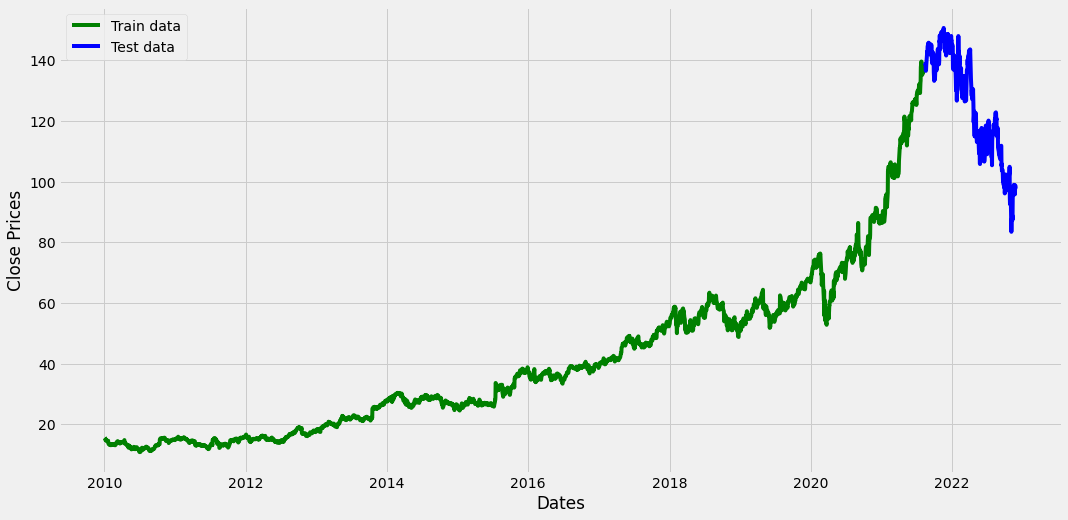

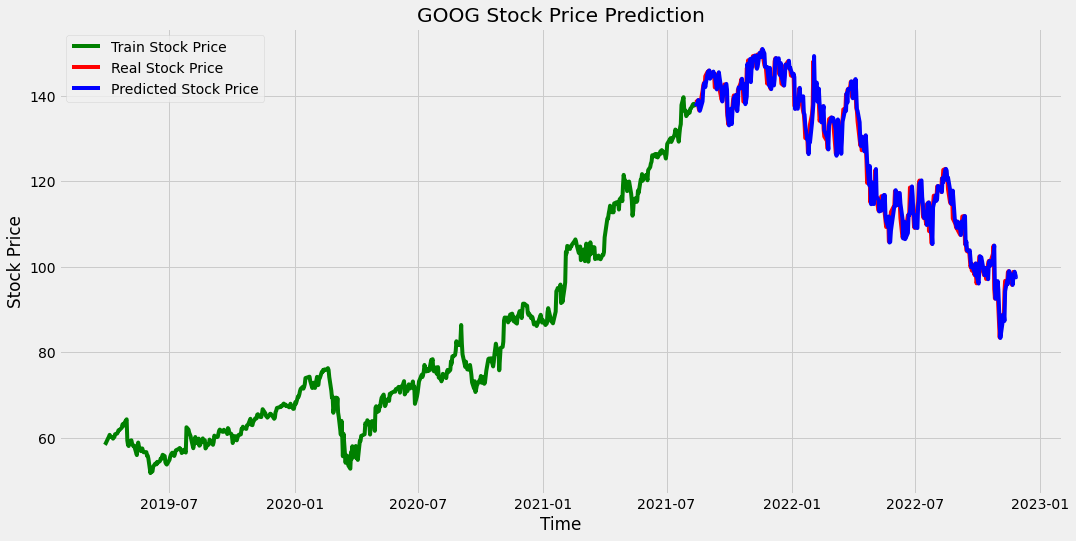

Tomorrow's GOOG  Closing Price Prediction by ARIMA:            Date  predictions
324  2022-11-25    98.863206
325  2022-11-26    98.110205


In [86]:
ARIMA_model(df_ticker_data)
arima_pred = df_pred.tail(2)
print("Tomorrow's",ticker," Closing Price Prediction by ARIMA:",arima_pred)

----------------------------------------------------------
----------------------------------------------------------
MSE: 6.952427687460599
MAE: 1.994669989305308
RMSE: 2.6367456622625927
Accuracy:0.9772371978991486
----------------------------------------------------------


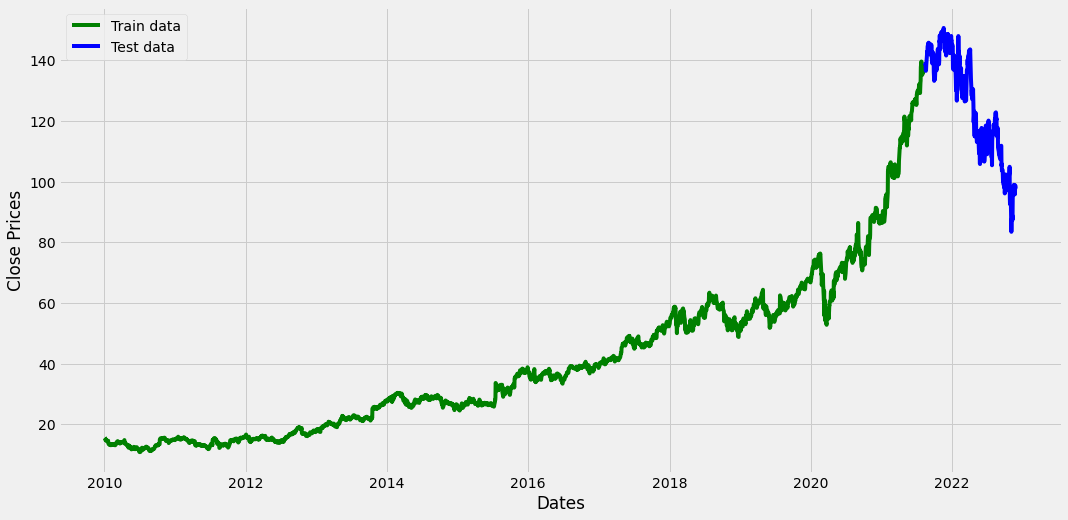

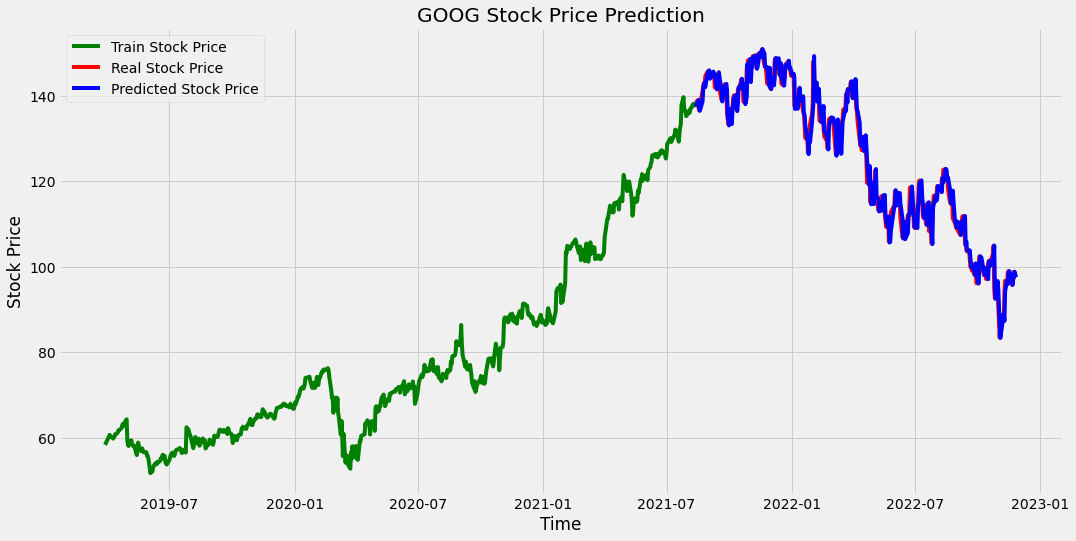

NameError: name 'ARIMAmodel' is not defined

In [76]:

#df_pred = pd.DataFrame()
df_pred = ARIMA_model(df_ticker)